## Import liabrary

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import plotly.express as px
import seaborn as sns

## Load the data

In [3]:
users_data = pd.read_csv("../data/users.csv")
games_data = pd.read_csv("../data/games.csv")
rec_data = pd.read_csv("../data/recommendations.csv")
meta_data = pd.read_json("../data/games_metadata.json", lines = True)

In [4]:
print(users_data.shape)
print(games_data.shape)
print(rec_data.shape)
print(meta_data.shape)

(57973, 3)
(50872, 13)
(4354674, 8)
(50872, 3)


In [5]:
users_data.head(3)

,user_id,products,reviews
0,11316351,677,68
1,4363012,1001,72
2,4893896,496,50


In [6]:
games_data.head(3)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True


In [7]:
rec_data.head(3)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,602960,0,0,2022-01-05,True,41.9,737481,58
1,570940,348,39,2021-12-11,False,73.3,5136277,138
2,39210,0,0,2021-04-09,True,123.1,5261084,141


In [8]:
meta_data.head(3)

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."


## EDA

In [9]:
print("This reduced data has {}% sparsity".format(rec_data.shape[0] / (users_data.shape[0] * games_data.shape[0]) * 100))

This reduced data has 0.1476559871683492% sparsity


PRICE OF GAMES ON STEAM

In [10]:
df = games_data

fig = px.scatter(df, x=df.index, y='price_final', title='Game Price Distribution',template='ggplot2',
                 labels={'index': 'Steam Games', 'price_final': 'Price'})

fig.update_traces(hovertemplate='<b>Títle:</b> %{text}<br><b>Price:</b> $%{y:.2f}', text=df['title'])

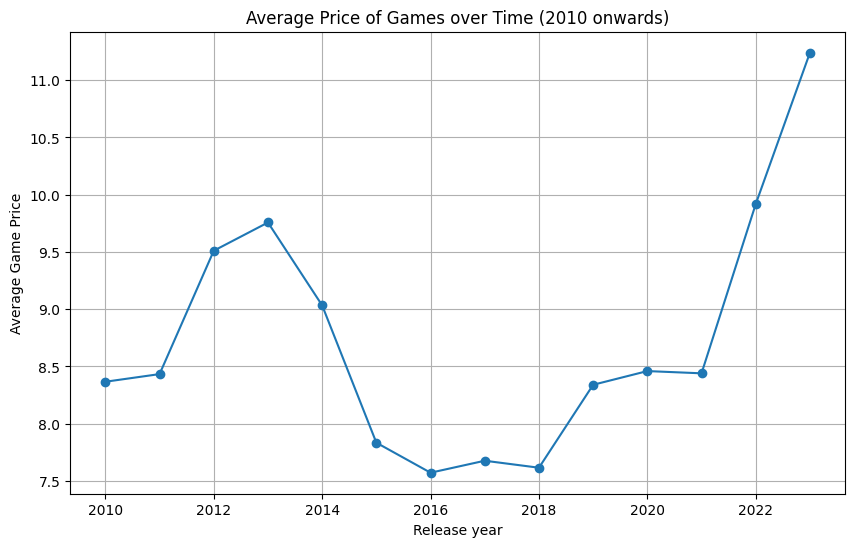

In [11]:
df['date_release'] = pd.to_datetime(df['date_release'])

df = df[df['date_release'].dt.year >= 2010]

average_prices = df.groupby(df['date_release'].dt.year)['price_final'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_prices.index, average_prices.values, marker='o')
plt.xlabel('Release year')
plt.ylabel('Average Game Price')
plt.title('Average Price of Games over Time (2010 onwards)')
plt.grid(True)

plt.show()

In [12]:
games_data.price_final.describe(percentiles=[.2,.4,.6,.8])

count    50872.000000
mean         8.620325
std         11.514164
min          0.000000
20%          0.740000
40%          3.590000
50%          4.990000
60%          7.490000
80%         14.990000
max        299.990000
Name: price_final, dtype: float64

The price that users spend for games

In [13]:
merged_data = pd.merge(rec_data, games_data, on='app_id', how='left')
average_price_per_user = merged_data.groupby('user_id')['price_final'].mean().reset_index()
users_price = pd.merge(users_data, average_price_per_user, on='user_id', how='left')
users_price.rename(columns = {"price_final" :"price_average"}, inplace = True)

In [14]:
users_price

,user_id,products,reviews,price_average
0,11316351,677,68,13.918824
1,4363012,1001,72,15.304167
2,4893896,496,50,15.389800
3,6366584,1597,129,16.350465
4,11140739,286,79,20.562405
...,...,...,...,...
57968,2019266,49,41,19.119268
57969,2077327,228,128,8.767109
57970,2820915,117,75,6.536667
57971,3954523,137,46,10.749783


In [15]:
users_price.price_average.describe(percentiles=[.2,.4,.6,.8])

count    57973.000000
mean        16.512424
std          5.730180
min          0.018679
20%         11.632640
40%         14.933533
50%         16.358889
60%         17.824463
80%         21.339714
max         43.565952
Name: price_average, dtype: float64

In [35]:
all_prices = pd.DataFrame(users_price['price_average'].tolist() + games_data['price_final'].tolist())

In [37]:
k = 10
quantiles = np.linspace(0, 1, k + 1)
bins = all_prices.quantile(quantiles)
bins

,0
0.0,0.000000
0.1,0.990000
0.2,3.990000
0.3,6.990000
0.4,9.990000
0.5,12.818478
0.6,14.990000
0.7,17.340382
0.8,19.990000
0.9,23.262164


RATING OF GAMES ON STEAM

The rating of games on Steam based on the number of reviews and positive ratio that this game gets in the real-life , Steam publisher propose a stategy to evaluate the game: 

95-100| 500 + reviews|positive|overwhelming

85-100| 50 + reviews|positive|very

80-100| 1 + reviews|positive

70-79| 1 + reviews|positive|mostly

40-69| 1 + reviews|mixed

20-39| 1 + reviews|negative|mostly

0-19| 1 + reviews|negative

95-100| 50 + reviews|negative|very

95-100| 500 + reviews|negative|overwhelming

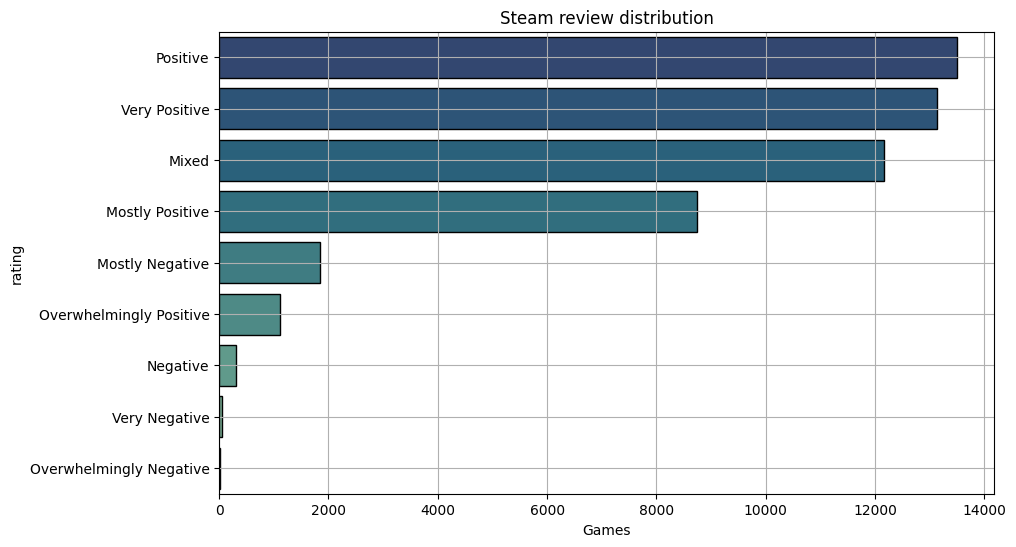

In [20]:
custom_order = [
     'Positive','Very Positive', 'Mixed', 'Mostly Positive',
     'Mostly Negative', 'Overwhelmingly Positive',
     'Negative',  'Very Negative','Overwhelmingly Negative'
]
ratings_count= games_data.rating.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(y=custom_order, x=ratings_count, palette='crest_r' ,edgecolor='k')
plt.ylabel('rating',fontsize=10)
plt.xlabel('Games',fontsize=10)
plt.title('Steam review distribution')
plt.grid(True)
plt.show()

GENRE(OR TAGS) OF GAMES ON STEAM

In [21]:
print("The average number of tags that a game is attached is",meta_data.tags.apply(lambda x : len(x)).sum()/len(meta_data), "tags")

The average number of tags that a game is attached is 11.484018713634219 tags


In [22]:
print("There are {} tags for all of games on Steam".format(len(meta_data.tags.explode().unique())))

There are 442 tags for all of games on Steam


In [23]:
from sklearn.feature_selection import mutual_info_classif
tags_list = list(set(tag for sublist in meta_data['tags'] for tag in sublist))
tags_df = pd.DataFrame(0, index=meta_data.index, columns=tags_list)
for i, tags in enumerate(meta_data['tags']):
    for tag in tags:
        tags_df.at[i, tag] = 1
# Create matrix game-table
game_labels = meta_data['app_id']
# Calculate Mutual Information
mi = mutual_info_classif(tags_df, game_labels, discrete_features=True)
# Choose 10 tags having highest value MI
top_tags_indices = np.argsort(mi)[-10:]
top_tags = tags_df.columns[top_tags_indices]
print("Top 10 most import tags based on  Mutual Information:", [tag for tag in top_tags])

Top 10 most import tags based on  Mutual Information: ['Atmospheric', 'RPG', 'Strategy', '2D', 'Simulation', 'Casual', 'Adventure', 'Action', 'Singleplayer', 'Indie']


User products

For the products the user buy, we will convert it into binary value 0-1 with many intervals, equal to 1 if the products in this interval, the number of intervals based on Sturges' Rule, and the milestones for each interval based on qunatile.

In [24]:
# Sturges' Rule
k = 5
quantiles = np.linspace(0, 1, k + 1)
bins = users_data['products'].quantile(quantiles)
bins

0.0        3.0
0.2      197.0
0.4      324.0
0.6      513.0
0.8      936.0
1.0    30108.0
Name: products, dtype: float64

## HYPOTHESIS FOR ASSIGN RATING

The explicit rating = implicit rating (1 if is recommended, -1 else) +   hour points

The hours point is calculated based on the true hourse lies on which quantiles, range from (2,4)

In [25]:
k = 5
quantiles = np.linspace(0, 1, k + 1)
rec_data['hours'].quantile(quantiles)

0.0      0.0
0.2      2.0
0.4      6.0
0.6     14.1
0.8     39.7
1.0    999.9
Name: hours, dtype: float64